In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import scipy.stats as st

#remove warning messages that are annoyting >:(
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def month_only(data):
    split = data.split('-')
    return(f'{split[0]}-{split[1]}')

In [3]:
df1 = pd.read_csv('raw_datasets/df_Counties2020.csv')
df1 = df1[df1['ST_Name'] == 'Texas']
df1 = df1.groupby('dt').sum()
df1 = df1.reset_index()
df1['month_year'] = df1.dt.apply(month_only)
data1 = pd.DataFrame(df1.groupby('month_year').NewCases.mean())
data1 = data1.reset_index()
data1.rename(columns={'NewCases':'cases'}, inplace=True)
data1.cases = round(data1.cases, 0)
data1.head()

,month_year,cases
0,2020-01,0.0
1,2020-02,0.0
2,2020-03,123.0
3,2020-04,836.0
4,2020-05,1157.0


In [4]:
df2 = pd.read_csv('raw_datasets/State_Trend_Data.csv')
df2 = df2[df2['state'] == 'Texas']
df2 = df2.dropna()
df2['month_year'] = df2.date.apply(month_only)
data2 = pd.DataFrame(df2.groupby('month_year').casechange.mean())
data2 = data2.reset_index()
data2.rename(columns={'casechange':'cases'}, inplace=True)
data2.cases = round(data2.cases, 0)
data2.head()


,month_year,cases
0,2020-12,21220.0
1,2021-01,19499.0
2,2021-02,10121.0
3,2021-03,4493.0
4,2021-04,3331.0


In [5]:
#merge
data = pd.concat([data1, data2])
#average the duplicants
data = data.groupby('month_year', as_index=False).mean()
data.head()

,month_year,cases
0,2020-01,0.0
1,2020-02,0.0
2,2020-03,123.0
3,2020-04,836.0
4,2020-05,1157.0


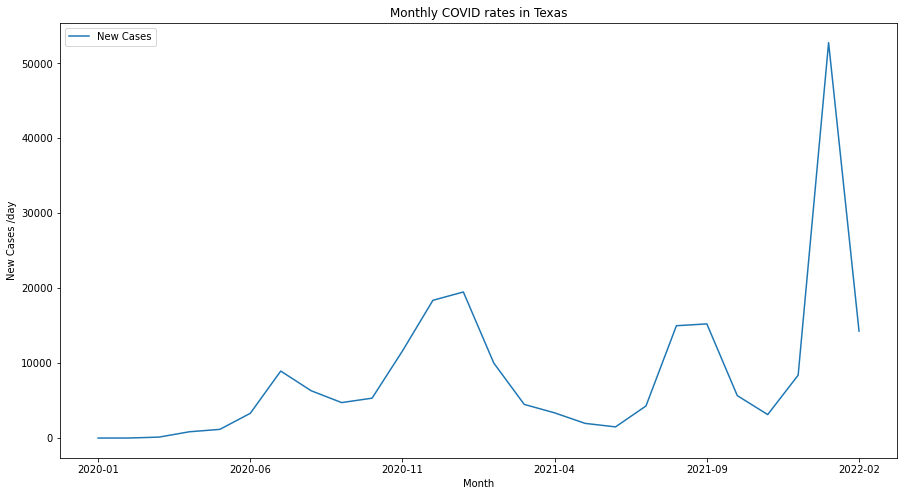

In [6]:
data.plot('month_year','cases', figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('New Cases /day')
plt.legend(['New Cases'])
plt.title('Monthly COVID rates in Texas')
plt.savefig('plots/Texas_cases_monthly.png')
plt.show()

In [7]:
#get the cat/dog data ...
cat_adoption = pd.read_csv('./clean_datasets/cat_adoption.csv').rename(columns = {'month':'month_year', 'outcome_type':'cat_adoption'})
cat_surrender = pd.read_csv('./clean_datasets/cat_surrender.csv').rename(columns = {'month':'month_year', 'outcome_type':'cat_surrender'})
dog_adoption = pd.read_csv('./clean_datasets/dog_adoption.csv').rename(columns = {'month':'month_year', 'outcome_type':'dog_adoption'})
dog_surrender = pd.read_csv('./clean_datasets/dog_surrender.csv').rename(columns = {'month':'month_year', 'outcome_type':'dog_surrender'})

In [8]:
merge_cat = pd.merge(cat_adoption, cat_surrender)
merge_dog = pd.merge(dog_adoption, dog_surrender)
merge_animals = pd.merge(merge_cat, merge_dog)
merge_data = pd.merge(data, merge_animals, how='outer')
all_dates = pd.DataFrame({'month_year':pd.date_range(min(merge_data.month_year),max(merge_data.month_year), freq='MS').strftime("%Y-%m"), 'blank':''})
merge_data = pd.merge(merge_data, all_dates, how='outer')
merge_data = merge_data.sort_values('month_year')
merge_data.to_csv('./clean_datasets/all_merged_data.csv')

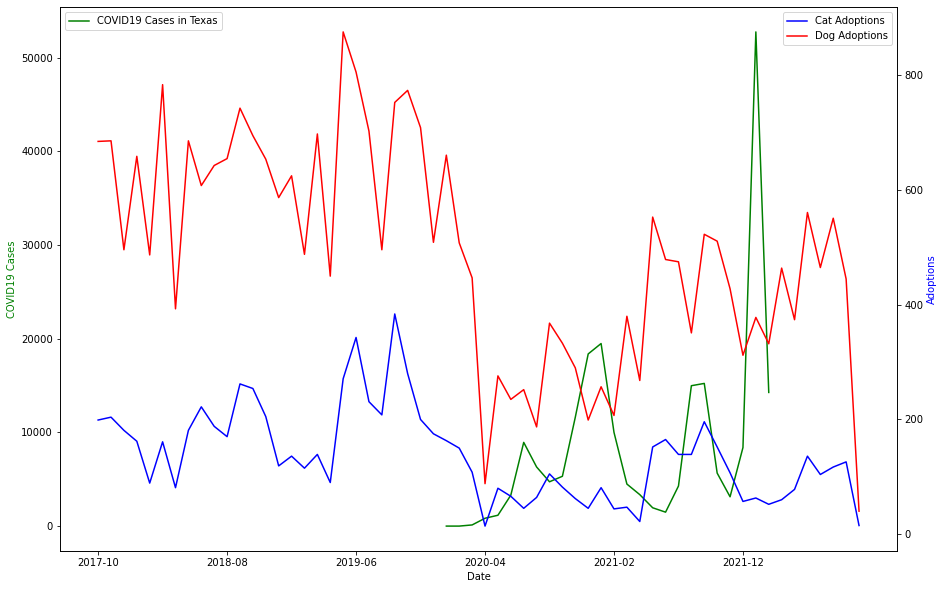

In [9]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax2 = ax1.twinx()
ax1.plot(merge_data.month_year, merge_data.cases, 'g-')
ax2.plot(merge_data.month_year, merge_data.cat_adoption, 'b-')
ax2.plot(merge_data.month_year, merge_data.dog_adoption, 'r-')
ax2.legend(['Cat Adoptions', 'Dog Adoptions'])
ax1.legend(['COVID19 Cases in Texas'], loc = 'upper left')

ax1.set_xlabel('Date')
ax1.set_ylabel('COVID19 Cases', color='g')
ax2.set_ylabel('Adoptions', color='b')


plt.xticks(merge_data.month_year[::10], rotation=45)
plt.savefig('plots/adoptions_cases.png')
plt.show()

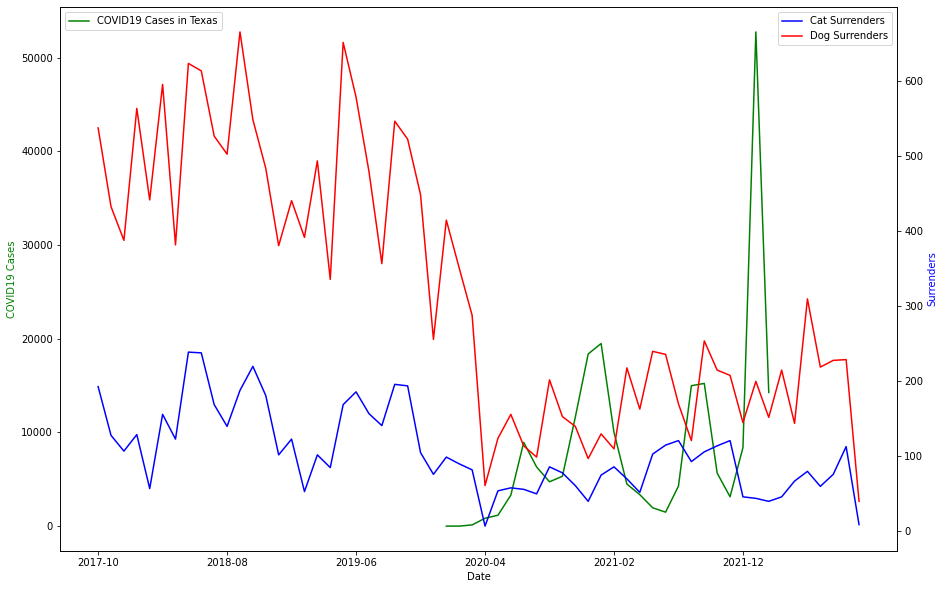

In [10]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax2 = ax1.twinx()
ax1.plot(merge_data.month_year, merge_data.cases, 'g-')
ax2.plot(merge_data.month_year, merge_data.cat_surrender, 'b-')
ax2.plot(merge_data.month_year, merge_data.dog_surrender, 'r-')
ax2.legend(['Cat Surrenders', 'Dog Surrenders'])
ax1.legend(['COVID19 Cases in Texas'], loc = 'upper left')

ax1.set_xlabel('Date')
ax1.set_ylabel('COVID19 Cases', color='g')
ax2.set_ylabel('Surrenders', color='b')

plt.xticks(merge_data.month_year[::10], rotation=45)
plt.savefig('plots/surrender_cases.png')
plt.show()

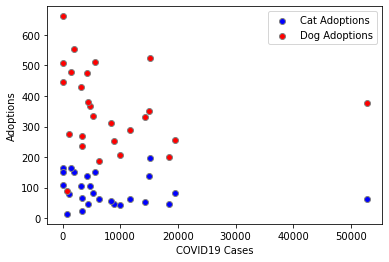

In [22]:
#adoption vs cases

linreg1 = st.linregress(merge_data.cases, merge_data.cat_adoption)
linreg2 = st.linregress(merge_data.cases, merge_data.dog_adoption)

plt.scatter(merge_data.cases, merge_data.cat_adoption, c='blue', edgecolors='grey')
plt.scatter(merge_data.cases, merge_data.dog_adoption, c='red', edgecolors='grey')

plt.plot(merge_data.cases, merge_data.cases*linreg1[0]+linreg1[1], color = 'blue')
plt.plot(merge_data.cases, merge_data.cases*linreg2[0]+linreg2[1], color = 'red')

plt.legend(['Cat Adoptions', 'Dog Adoptions'])
plt.xlabel('COVID19 Cases')
plt.ylabel('Adoptions')
plt.show()